In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

from src.const import SEED
from src.evaluation import eval_acc_in_binary_task
from src.preprocess import transform_to_data_loader
from src.preprocess_utils import create_binary_labels
from src.train import train_model
from src.visualization import plot_conf_matrix, plot_losses

In [2]:
CLASSES = ['known', 'unknown']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load data

In [4]:
X_train = np.load('data/arrays/X_train.npy')
y_train = np.load('data/arrays/y_train.npy')
X_val = np.load('data/arrays/X_val.npy')
y_val = np.load('data/arrays/y_val.npy')
X_test = np.load('data/arrays/X_test.npy')
y_test = np.load('data/arrays/y_test.npy')

Transform labels for binary task

In [5]:
y_train = create_binary_labels(y_train)
y_val = create_binary_labels(y_val)
y_test = create_binary_labels(y_test)

Generate data loaders for train and validation

In [6]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

In [7]:
for x, y in train_dl:
    print(f'Input size: {x.shape}')
    print(f'Labels size: {y.shape}')
    break

Input size: torch.Size([128, 99, 20])
Labels size: torch.Size([128])


## Models

### Transformer

In [8]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, dropout_rate=0.3, units=512):
        
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True, activation="relu").to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(d_model, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [9]:
d_model = 20
n_head = 4
num_layers = 3
dropout_rate = 0.3
units = 64

transformer_model = Transformer(d_model, n_head, num_layers, dropout_rate, units).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(transformer_model.parameters(), weight_decay=1e-5)

In [10]:
summary(transformer_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [128, 1]                  85,748
├─TransformerEncoder: 1-1                     [128, 99, 20]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 99, 20]             85,748
│    │    └─TransformerEncoderLayer: 3-2      [128, 99, 20]             85,748
│    │    └─TransformerEncoderLayer: 3-3      [128, 99, 20]             85,748
├─Dropout: 1-2                                [128, 20]                 --
├─BatchNorm1d: 1-3                            [128, 20]                 40
├─Linear: 1-4                                 [128, 64]                 1,344
├─Dropout: 1-5                                [128, 64]                 --
├─ReLU: 1-6                                   [128, 64]                 --
├─BatchNorm1d: 1-7                            [128, 64]                 128


In [11]:
train_losses, val_losses = train_model(
    model=transformer_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 400/400 [00:32<00:00, 12.42it/s]


Epoch 1/50, Train Loss: 0.5569, Train Acc: 0.70, Val Loss: 0.4464, Val Acc: 0.79


Epoch 2: 100%|██████████| 400/400 [00:31<00:00, 12.52it/s]


Epoch 2/50, Train Loss: 0.4168, Train Acc: 0.81, Val Loss: 0.4048, Val Acc: 0.81


Epoch 3: 100%|██████████| 400/400 [00:32<00:00, 12.47it/s]


Epoch 3/50, Train Loss: 0.3731, Train Acc: 0.84, Val Loss: 0.3538, Val Acc: 0.84


Epoch 4: 100%|██████████| 400/400 [00:32<00:00, 12.46it/s]


Epoch 4/50, Train Loss: 0.3395, Train Acc: 0.85, Val Loss: 0.3253, Val Acc: 0.86


Epoch 5: 100%|██████████| 400/400 [00:32<00:00, 12.33it/s]


Epoch 5/50, Train Loss: 0.3208, Train Acc: 0.86, Val Loss: 0.3109, Val Acc: 0.87


Epoch 6: 100%|██████████| 400/400 [00:32<00:00, 12.32it/s]


Epoch 6/50, Train Loss: 0.2977, Train Acc: 0.87, Val Loss: 0.2986, Val Acc: 0.88


Epoch 7: 100%|██████████| 400/400 [00:32<00:00, 12.28it/s]


Epoch 7/50, Train Loss: 0.2780, Train Acc: 0.88, Val Loss: 0.2997, Val Acc: 0.86


Epoch 8: 100%|██████████| 400/400 [00:32<00:00, 12.18it/s]


Epoch 8/50, Train Loss: 0.2635, Train Acc: 0.89, Val Loss: 0.2663, Val Acc: 0.89


Epoch 9: 100%|██████████| 400/400 [00:32<00:00, 12.27it/s]


Epoch 9/50, Train Loss: 0.2461, Train Acc: 0.90, Val Loss: 0.2576, Val Acc: 0.89


Epoch 10: 100%|██████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch 10/50, Train Loss: 0.2375, Train Acc: 0.90, Val Loss: 0.2594, Val Acc: 0.89


Epoch 11: 100%|██████████| 400/400 [00:33<00:00, 11.97it/s]


Epoch 11/50, Train Loss: 0.2233, Train Acc: 0.91, Val Loss: 0.2476, Val Acc: 0.90


Epoch 12: 100%|██████████| 400/400 [00:32<00:00, 12.21it/s]


Epoch 12/50, Train Loss: 0.2163, Train Acc: 0.91, Val Loss: 0.2531, Val Acc: 0.90


Epoch 13: 100%|██████████| 400/400 [00:32<00:00, 12.30it/s]


Epoch 13/50, Train Loss: 0.2038, Train Acc: 0.92, Val Loss: 0.2341, Val Acc: 0.90


Epoch 14: 100%|██████████| 400/400 [00:33<00:00, 12.07it/s]


Epoch 14/50, Train Loss: 0.1985, Train Acc: 0.92, Val Loss: 0.2288, Val Acc: 0.91


Epoch 15: 100%|██████████| 400/400 [00:32<00:00, 12.17it/s]


Epoch 15/50, Train Loss: 0.1911, Train Acc: 0.92, Val Loss: 0.2610, Val Acc: 0.90


Epoch 16: 100%|██████████| 400/400 [00:34<00:00, 11.54it/s]


Epoch 16/50, Train Loss: 0.1842, Train Acc: 0.92, Val Loss: 0.2481, Val Acc: 0.90


Epoch 17: 100%|██████████| 400/400 [00:33<00:00, 11.85it/s]


Epoch 17/50, Train Loss: 0.1778, Train Acc: 0.93, Val Loss: 0.2348, Val Acc: 0.91
Early stopping


#### Evaluation

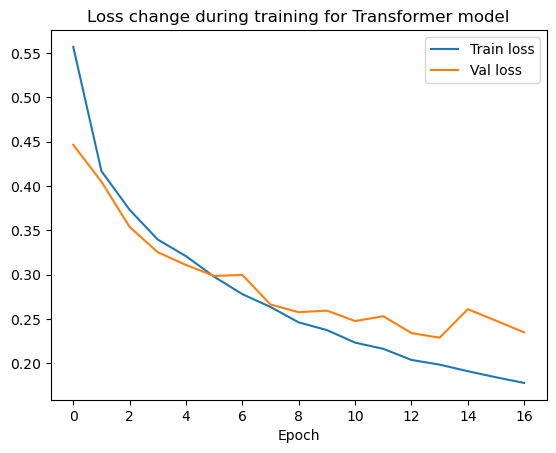

In [12]:
plot_losses(train_losses, val_losses, "Loss change during training for Transformer model")

In [ ]:
# eval_acc_in_binary_task(transformer_model, X_train, y_train, 'Train', device)
# eval_acc_in_binary_task(transformer_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(transformer_model, X_test, y_test, 'Test', device)

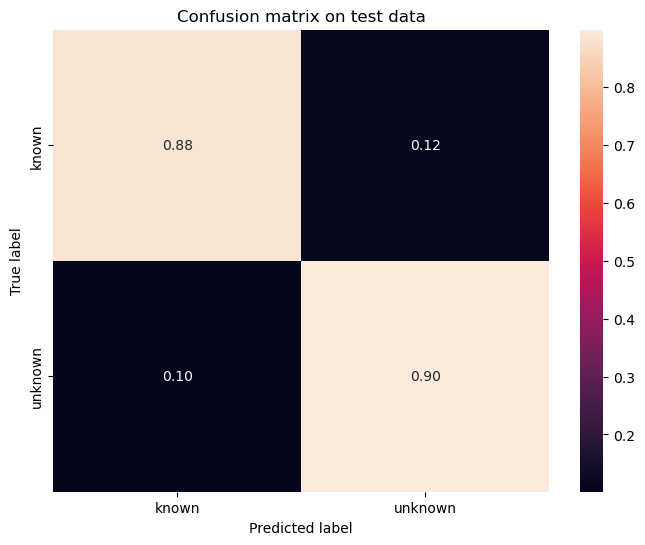

In [15]:
plot_conf_matrix(y_test, y_pred, CLASSES)

### GRU

In [35]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=512, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.gru(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [36]:
input_size = 20
hidden_size = 64
num_layers = 4

gru_model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), weight_decay=1e-5)

c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [37]:
summary(gru_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 1]                  --
├─GRU: 1-1                               [128, 99, 64]             91,392
├─Dropout: 1-2                           [128, 64]                 --
├─BatchNorm1d: 1-3                       [128, 64]                 128
├─Linear: 1-4                            [128, 512]                33,280
├─Dropout: 1-5                           [128, 512]                --
├─ReLU: 1-6                              [128, 512]                --
├─BatchNorm1d: 1-7                       [128, 512]                1,024
├─Linear: 1-8                            [128, 1]                  513
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
Total mult-adds (G): 1.16
Input size (MB): 1.01
Forward/backward pass size (MB): 7.60
Params size (MB): 0.51
Estimated Total Size (MB): 9.12

In [38]:
train_losses, val_losses = train_model(
    model=gru_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 400/400 [00:05<00:00, 77.84it/s]


Epoch 1/50, Train Loss: 0.6281, Train Acc: 0.65, Val Loss: 0.5450, Val Acc: 0.73


Epoch 2: 100%|██████████| 400/400 [00:05<00:00, 77.27it/s]


Epoch 2/50, Train Loss: 0.4350, Train Acc: 0.79, Val Loss: 0.3807, Val Acc: 0.84


Epoch 3: 100%|██████████| 400/400 [00:05<00:00, 77.10it/s]


Epoch 3/50, Train Loss: 0.2811, Train Acc: 0.88, Val Loss: 0.2522, Val Acc: 0.90


Epoch 4: 100%|██████████| 400/400 [00:05<00:00, 75.74it/s]


Epoch 4/50, Train Loss: 0.2133, Train Acc: 0.92, Val Loss: 0.2759, Val Acc: 0.88


Epoch 5: 100%|██████████| 400/400 [00:05<00:00, 75.48it/s]


Epoch 5/50, Train Loss: 0.1841, Train Acc: 0.93, Val Loss: 0.2337, Val Acc: 0.91


Epoch 6: 100%|██████████| 400/400 [00:05<00:00, 77.83it/s]


Epoch 6/50, Train Loss: 0.1635, Train Acc: 0.94, Val Loss: 0.1462, Val Acc: 0.94


Epoch 7: 100%|██████████| 400/400 [00:05<00:00, 77.24it/s]


Epoch 7/50, Train Loss: 0.1493, Train Acc: 0.94, Val Loss: 0.1668, Val Acc: 0.93


Epoch 8: 100%|██████████| 400/400 [00:05<00:00, 77.37it/s]


Epoch 8/50, Train Loss: 0.1384, Train Acc: 0.95, Val Loss: 0.1347, Val Acc: 0.95


Epoch 9: 100%|██████████| 400/400 [00:05<00:00, 77.19it/s]


Epoch 9/50, Train Loss: 0.1285, Train Acc: 0.95, Val Loss: 0.1333, Val Acc: 0.95


Epoch 10: 100%|██████████| 400/400 [00:05<00:00, 77.78it/s]


Epoch 10/50, Train Loss: 0.1197, Train Acc: 0.95, Val Loss: 0.1405, Val Acc: 0.94


Epoch 11: 100%|██████████| 400/400 [00:05<00:00, 74.96it/s]


Epoch 11/50, Train Loss: 0.1117, Train Acc: 0.96, Val Loss: 0.1253, Val Acc: 0.95


Epoch 12: 100%|██████████| 400/400 [00:05<00:00, 73.99it/s]


Epoch 12/50, Train Loss: 0.1065, Train Acc: 0.96, Val Loss: 0.1610, Val Acc: 0.93


Epoch 13: 100%|██████████| 400/400 [00:05<00:00, 74.97it/s]


Epoch 13/50, Train Loss: 0.1013, Train Acc: 0.96, Val Loss: 0.1148, Val Acc: 0.95


Epoch 14: 100%|██████████| 400/400 [00:05<00:00, 73.03it/s]


Epoch 14/50, Train Loss: 0.0951, Train Acc: 0.96, Val Loss: 0.1180, Val Acc: 0.95


Epoch 15: 100%|██████████| 400/400 [00:05<00:00, 73.38it/s]


Epoch 15/50, Train Loss: 0.0896, Train Acc: 0.96, Val Loss: 0.1318, Val Acc: 0.95


Epoch 16: 100%|██████████| 400/400 [00:05<00:00, 73.44it/s]


Epoch 16/50, Train Loss: 0.0850, Train Acc: 0.97, Val Loss: 0.1093, Val Acc: 0.96


Epoch 17: 100%|██████████| 400/400 [00:05<00:00, 74.99it/s]


Epoch 17/50, Train Loss: 0.0815, Train Acc: 0.97, Val Loss: 0.1018, Val Acc: 0.96


Epoch 18: 100%|██████████| 400/400 [00:05<00:00, 74.89it/s]


Epoch 18/50, Train Loss: 0.0760, Train Acc: 0.97, Val Loss: 0.1053, Val Acc: 0.96


Epoch 19: 100%|██████████| 400/400 [00:05<00:00, 75.68it/s]


Epoch 19/50, Train Loss: 0.0736, Train Acc: 0.97, Val Loss: 0.1015, Val Acc: 0.96


Epoch 20: 100%|██████████| 400/400 [00:05<00:00, 72.53it/s]


Epoch 20/50, Train Loss: 0.0689, Train Acc: 0.97, Val Loss: 0.1028, Val Acc: 0.96


Epoch 21: 100%|██████████| 400/400 [00:05<00:00, 69.91it/s]


Epoch 21/50, Train Loss: 0.0681, Train Acc: 0.97, Val Loss: 0.1131, Val Acc: 0.96


Epoch 22: 100%|██████████| 400/400 [00:05<00:00, 70.83it/s]


Epoch 22/50, Train Loss: 0.0649, Train Acc: 0.97, Val Loss: 0.0994, Val Acc: 0.96


Epoch 23: 100%|██████████| 400/400 [00:05<00:00, 68.84it/s]


Epoch 23/50, Train Loss: 0.0605, Train Acc: 0.97, Val Loss: 0.1116, Val Acc: 0.96


Epoch 24: 100%|██████████| 400/400 [00:05<00:00, 72.97it/s]


Epoch 24/50, Train Loss: 0.0585, Train Acc: 0.98, Val Loss: 0.1041, Val Acc: 0.96


Epoch 25: 100%|██████████| 400/400 [00:05<00:00, 72.29it/s]


Epoch 25/50, Train Loss: 0.0560, Train Acc: 0.98, Val Loss: 0.1047, Val Acc: 0.96
Early stopping


#### Evaluation

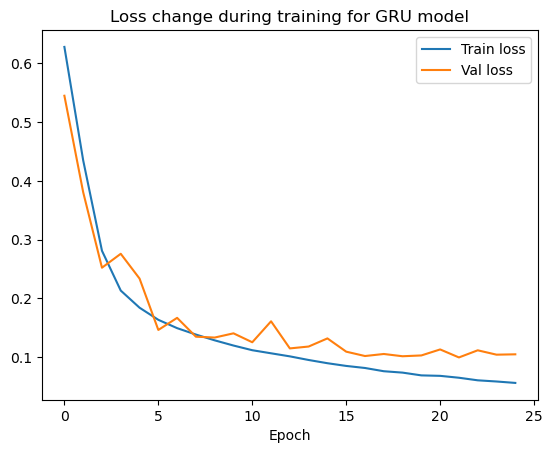

In [39]:
plot_losses(train_losses, val_losses, "Loss change during training for GRU model")

In [46]:
# eval_acc_in_binary_task(gru_model, X_train, y_train, 'Train', device)
eval_acc_in_binary_task(gru_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(gru_model, X_test, y_test, 'Test', device)

Validation accuracy: 0.9629
Test accuracy: 0.9409


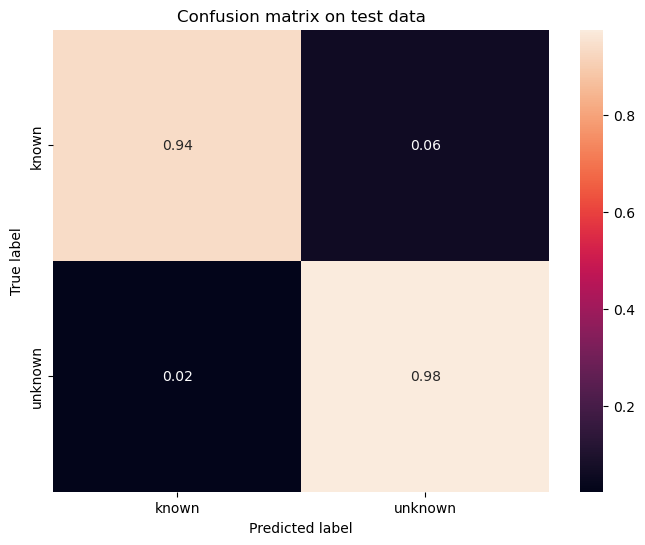

In [41]:
plot_conf_matrix(y_test, y_pred, CLASSES)

### BI-LSTM

In [8]:
class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=512, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2*hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [9]:
input_size = 20
hidden_size = 32
num_layers = 4

bilstm_model = BiLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), weight_decay=1e-5)

In [10]:
summary(bilstm_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 1]                  --
├─LSTM: 1-1                              [128, 99, 64]             89,088
├─Dropout: 1-2                           [128, 64]                 --
├─BatchNorm1d: 1-3                       [128, 64]                 128
├─Linear: 1-4                            [128, 512]                33,280
├─Dropout: 1-5                           [128, 512]                --
├─ReLU: 1-6                              [128, 512]                --
├─BatchNorm1d: 1-7                       [128, 512]                1,024
├─Linear: 1-8                            [128, 1]                  513
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 124,033
Trainable params: 124,033
Non-trainable params: 0
Total mult-adds (G): 1.13
Input size (MB): 1.01
Forward/backward pass size (MB): 7.60
Params size (MB): 0.50
Estimated Total Size (MB): 9.11

In [11]:
train_losses, val_losses = train_model(
    model=bilstm_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 400/400 [00:04<00:00, 86.52it/s]


Epoch 1/50, Train Loss: 0.6239, Train Acc: 0.65, Val Loss: 0.5674, Val Acc: 0.70


Epoch 2: 100%|██████████| 400/400 [00:04<00:00, 90.57it/s]


Epoch 2/50, Train Loss: 0.5064, Train Acc: 0.75, Val Loss: 0.4560, Val Acc: 0.77


Epoch 3: 100%|██████████| 400/400 [00:04<00:00, 90.61it/s]


Epoch 3/50, Train Loss: 0.4375, Train Acc: 0.79, Val Loss: 0.4295, Val Acc: 0.79


Epoch 4: 100%|██████████| 400/400 [00:04<00:00, 90.79it/s]


Epoch 4/50, Train Loss: 0.3717, Train Acc: 0.83, Val Loss: 0.4446, Val Acc: 0.77


Epoch 5: 100%|██████████| 400/400 [00:04<00:00, 89.47it/s]


Epoch 5/50, Train Loss: 0.3035, Train Acc: 0.87, Val Loss: 0.3957, Val Acc: 0.81


Epoch 6: 100%|██████████| 400/400 [00:04<00:00, 89.11it/s]


Epoch 6/50, Train Loss: 0.2512, Train Acc: 0.90, Val Loss: 0.2327, Val Acc: 0.91


Epoch 7: 100%|██████████| 400/400 [00:04<00:00, 89.97it/s]


Epoch 7/50, Train Loss: 0.2188, Train Acc: 0.91, Val Loss: 0.2144, Val Acc: 0.91


Epoch 8: 100%|██████████| 400/400 [00:04<00:00, 89.87it/s]


Epoch 8/50, Train Loss: 0.2028, Train Acc: 0.92, Val Loss: 0.1999, Val Acc: 0.92


Epoch 9: 100%|██████████| 400/400 [00:04<00:00, 90.00it/s]


Epoch 9/50, Train Loss: 0.1822, Train Acc: 0.93, Val Loss: 0.2028, Val Acc: 0.91


Epoch 10: 100%|██████████| 400/400 [00:04<00:00, 86.60it/s]


Epoch 10/50, Train Loss: 0.1736, Train Acc: 0.93, Val Loss: 0.1878, Val Acc: 0.93


Epoch 11: 100%|██████████| 400/400 [00:04<00:00, 88.66it/s]


Epoch 11/50, Train Loss: 0.1606, Train Acc: 0.94, Val Loss: 0.2607, Val Acc: 0.91


Epoch 12: 100%|██████████| 400/400 [00:04<00:00, 87.23it/s]


Epoch 12/50, Train Loss: 0.1529, Train Acc: 0.94, Val Loss: 0.2335, Val Acc: 0.92


Epoch 13: 100%|██████████| 400/400 [00:04<00:00, 87.81it/s]


Epoch 13/50, Train Loss: 0.1462, Train Acc: 0.94, Val Loss: 0.1901, Val Acc: 0.93
Early stopping


#### Evaluation

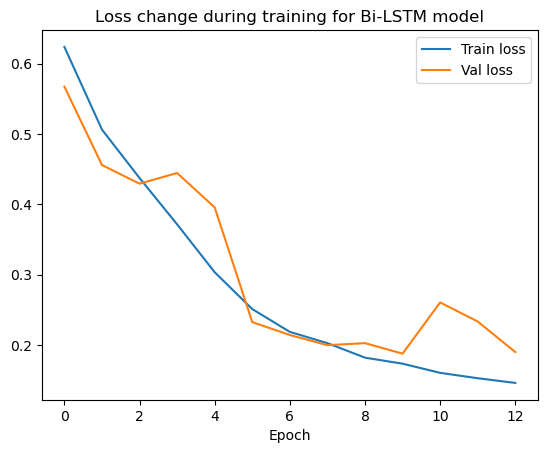

In [12]:
plot_losses(train_losses, val_losses, "Loss change during training for Bi-LSTM model")

In [16]:
# eval_acc_in_binary_task(bilstm_model, X_train, y_train, 'Train', device)
eval_acc_in_binary_task(bilstm_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(bilstm_model, X_test, y_test, 'Test', device)

Validation accuracy: 0.9254
Test accuracy: 0.9494


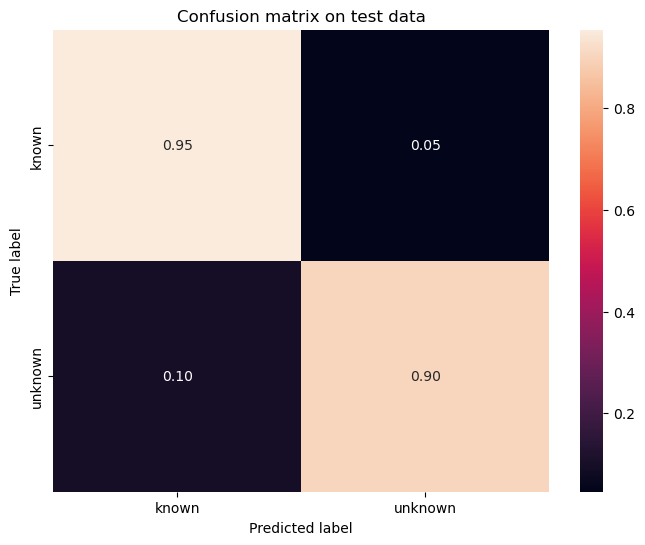

In [17]:
plot_conf_matrix(y_test, y_pred, CLASSES)

In [ ]:
# Save model dict as it is best model for this task
torch.save(bilstm_model.state_dict(), "unknown_best_model")